**Link:** [dsm.business/colab/class1](https://dsm.business/colab/class1)


&#9888; Begin by creating a personal copy of this notebook. Then run the code cell below to load all of the packages we will need.

In [1]:
install.packages(c("e1071", "rpart.plot","MLmetrics"))
library(tidyverse)
library(scales)
library(rpart.plot)
library(MLmetrics)

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘bitops’, ‘gtools’, ‘caTools’, ‘gplots’, ‘proxy’, ‘ROCR’


Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.4.0      ✔ purrr   0.3.5 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.3      ✔ forcats 0.5.2 

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

    discard


The following object is masked from ‘package:readr’:

    col_factor


Loading required package: rpart


Attaching package: ‘MLmetrics’


The following object is masked from ‘package:base’:

    Recall




# **Case:** Predicting Ticket Purchases at the Warriors

![Warriors.vresize.350.350.medium.0[1].png](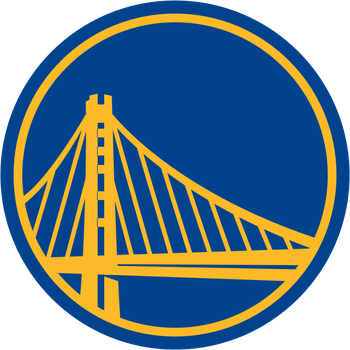)

In this notebook, we will perform the analyses described in the case *Data Science at the Warriors*. Do not worry about understanding the code, just run each cell and observe the output. You will understand all the code by the end of the course!

---

## Read in Data

Run the code cell below to read the Warriors data from a file into an R object called `warriorsData`. Note that for simplicity, we are working with a small, anonymized random sample of the full data set (1,000 observations). Each observation is the most recent transaction of a customer. 

The data contains the following variables:

+ `customerID`: A unique ID representing the customer who made the purchase.
+ `customerName`: The name of the customer who made the purchase.
+ `Age`: The age of the customer at the time of the purchase.
+ `Fan_Mailing_List`: A binary variable indicating whether the customer was on the fan mailing list (Yes or No).
+ `Customer_Type`: The customer type (Planner, In-Between, or Last-Minute).
+ `Game_ID`: A unique ID representing the game the tickets were purchased for. 
+ `Num_Tickets_Purchased`: The number of tickets purchased in the transaction.
+ `Seat_Location`: The location of the seats purchased (Upper or Lower).
+ `Ticket_Price`: The price of the ticket in U.S. dollars (or the average ticket price if multiple tickets were purchased). 
+ `Concession_Purchases`: The amount spent by the ticket purchaser on concessions during the game.
+ `Days_Before_Game`: The number of days between the date the ticket was purchased and the date of the game. 

In [2]:
system("gdown --id 12FGnAzTM2QWjS4YospNmA0x1s3xUItTU")
warriorsData <- read_csv("warriors_data.csv")
warriorsData$Customer_Type <- parse_factor(warriorsData$Customer_Type, 
                                levels=c("Last-Minute", "In-Between", "Planner"),
                                ordered=TRUE)
head(warriorsData)

Rows: 1000 Columns: 11
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (6): customerID, customerName, Fan_Mailing_List, Customer_Type, Game_ID,...
dbl (5): Age, Num_Tickets_Purchased, Ticket_Price, Concession_Purchases, Day...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


customerID,customerName,Age,Fan_Mailing_List,Customer_Type,Game_ID,Num_Tickets_Purchased,Seat_Location,Ticket_Price,Concession_Purchases,Days_Before_Game
<chr>,<chr>,<dbl>,<chr>,<ord>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
84d6d15c19b7ef14,"el-Sadek, Lateefa",42,No,Last-Minute,324fd36f67eb,2,Upper,307.64,13.92,2
4d570962be6afdbd,"el-Shahan, Wadee'a",61,Yes,In-Between,0c4f632e4414,1,Upper,324.07,18.47,14
aaabe0dae9c355d2,"Legge, Megan",27,No,Last-Minute,2f73386a1b02,4,Upper,291.51,3.24,0
64f0b74afeb534da,"Burrows, Keenan",32,Yes,Last-Minute,0bdd7a9ec446,2,Upper,184.92,0.00,2
e2bef2d7b2a2de4d,"Waggoner, Lucas",34,No,Last-Minute,7040d6183039,1,Upper,198.40,0.00,1
70313caeb6edc339,"Bonnet, Jessica",54,Yes,Planner,4b97f845624d,5,Lower,288.41,68.63,27


## Exploratory Data Analysis (EDA)

### **Part 1:** Basic summary

Run the code cells below for a basic summary of the data set.

In [3]:
names(warriorsData)

[1] "customerID"            "customerName"          "Age"                  
 [4] "Fan_Mailing_List"      "Customer_Type"         "Game_ID"              
 [7] "Num_Tickets_Purchased" "Seat_Location"         "Ticket_Price"         
[10] "Concession_Purchases"  "Days_Before_Game"

In [4]:
ncol(warriorsData)

[1] 11

In [5]:
nrow(warriorsData)

[1] 1000

In [6]:
sum(is.na(warriorsData))

[1] 0

### **Part 2:** Exploring individual variables

Now run the code cells below to calculate some basic summary statistics of the `Days_Before_Game` variable. 

In [7]:
min(warriorsData$Days_Before_Game)

[1] 0

In [8]:
max(warriorsData$Days_Before_Game)

[1] 36

In [9]:
mean(warriorsData$Days_Before_Game)

[1] 11.087

### **Part 3:** Scatter plot of `Age` v. `Days_Before_Game`

Run the code cell below to produce a scatter plot that visualizes the relationship between `Age` and `Days_Before_Game`.

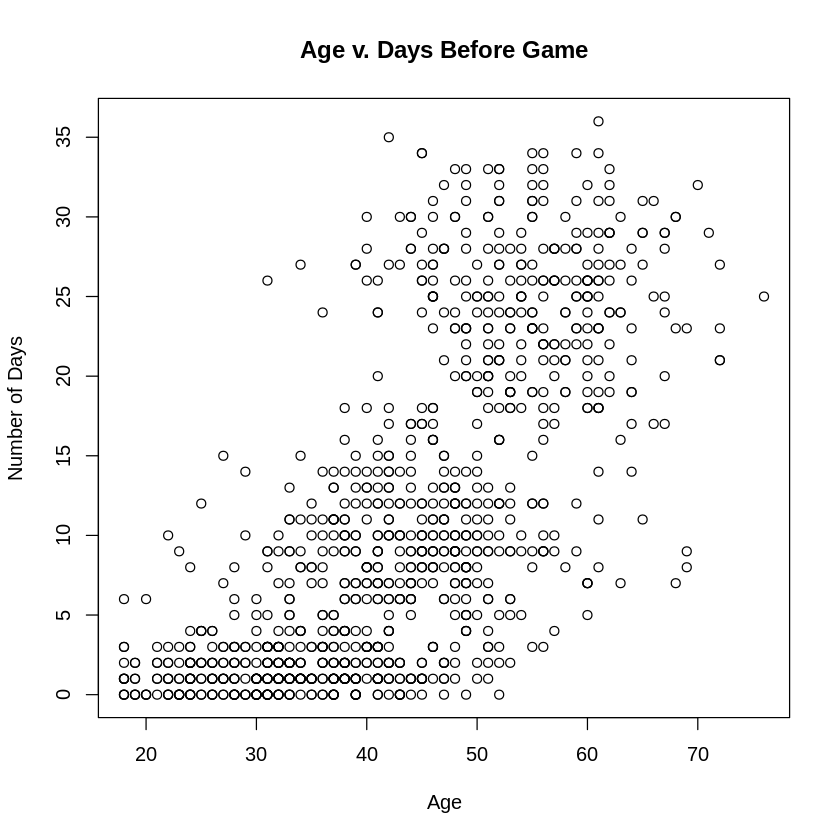

In [10]:
plot(warriorsData$Age, warriorsData$Days_Before_Game,
        main = "Age v. Days Before Game", xlab = "Age", ylab = "Number of Days")

### **Part 4:** Histogram of `Days_Before_Game`

Run the code cell below to create a histogram of the `Days_Before_Game` variable. What does this tell you about how far in advance people tend to purchase tickets?

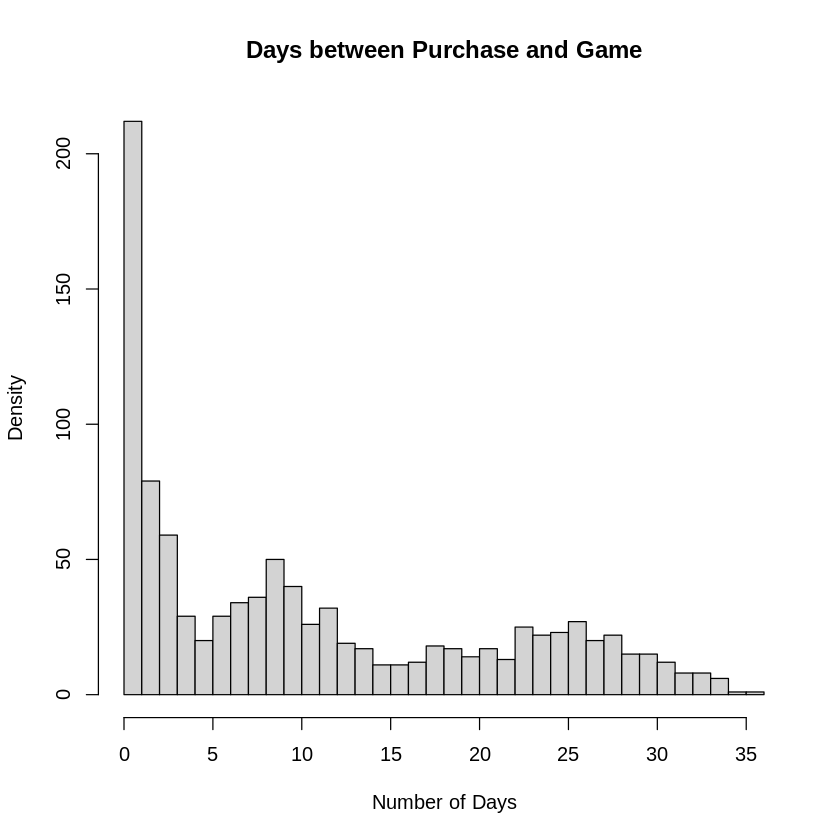

In [11]:
hist(warriorsData$Days_Before_Game,
        main = "Days between Purchase and Game", xlab = "Number of Days", ylab = "Density",
        breaks = 40)

### **Part 5:** Histogram of `Days_Before_Game` by `Customer_Type`

Now let's look at the same histogram, but color-coded by `Customer_Type`. What does this tell you about the relationship between `Customer_Type` and `Days_Before_Game`?

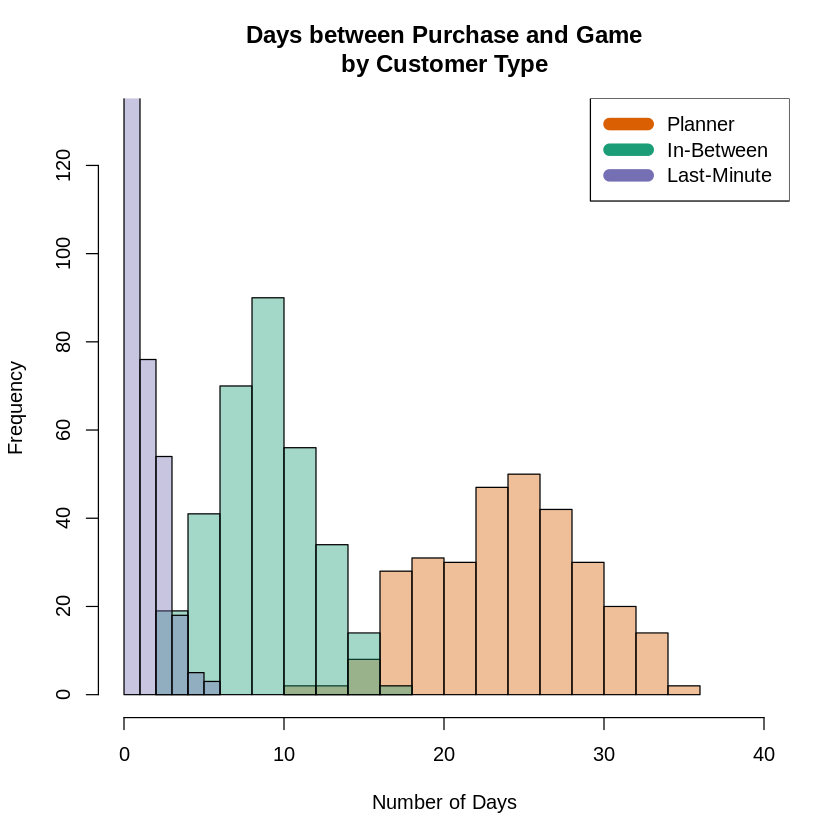

In [12]:
hg1 <- hist(warriorsData[warriorsData$Customer_Type=="Planner", ]$Days_Before_Game, plot = FALSE, breaks = 12)
hg2 <- hist(warriorsData[warriorsData$Customer_Type=="In-Between", ]$Days_Before_Game, plot = FALSE, breaks = 8)
hg3 <- hist(warriorsData[warriorsData$Customer_Type=="Last-Minute", ]$Days_Before_Game, plot = FALSE, breaks = 6)
plot(hg1, col = rgb(red = 217/256, green = 95/256, blue = 2/256, alpha = 0.4), xlim = c(0, 40), ylim = c(0, 130),
     xlab = "Number of Days", main = "Days between Purchase and Game\nby Customer Type")
plot(hg2, col = rgb(red = 27/256, green = 158/256, blue = 119/256, alpha = 0.4), alpha = 0.4, add = TRUE)
plot(hg3, col = rgb(red = 117/256, green = 112/256, blue = 179/256, alpha = 0.4), alpha = 0.4, add = TRUE)
legend("topright", c("Planner", "In-Between", "Last-Minute"),
              col=c("#d95f02", "#1b9e77", "#7570b3"), lwd = 10)

### **Part 6:** Boxplot of `Days_Before_Game` by `Seat_Location`

Run the code cell below to create a side-by-side boxplot. Is this enough to conclude that, on average, tickets in the lower bowl of the stadium sell closer to game time, while tickets in the upper bowl sell slightly more in advance?

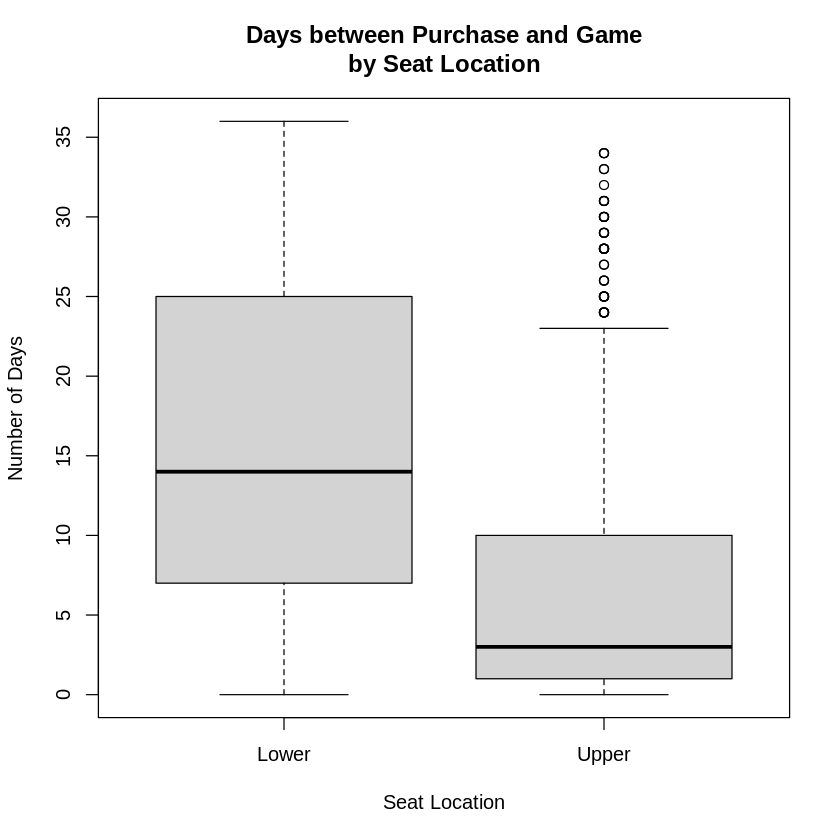

In [13]:
boxplot(warriorsData$Days_Before_Game ~ warriorsData$Seat_Location,
          main = "Days between Purchase and Game\nby Seat Location", xlab = "Seat Location", 
          ylab = "Number of Days")

### **Part 7:** Your turn

Create a scatterplot or boxplot that explores one or two variables we did not cover above. To do this, simply copy and paste the relevant code. Then, swap out the variable names.

In [14]:
# YOUR CODE HERE

## Inference

Run the cell below to conduct a hypothesis test that compares `Days_Before_Game` between the upper and lower bowls. Is there sufficient evidence to conclude there really is a difference? How can you tell?

In [15]:
t.test(warriorsData$Days_Before_Game ~ warriorsData$Seat_Location)


	Welch Two Sample t-test

data:  warriorsData$Days_Before_Game by warriorsData$Seat_Location
t = 14.237, df = 944.9, p-value < 2.2e-16
alternative hypothesis: true difference in means between group Lower and group Upper is not equal to 0
95 percent confidence interval:
 7.160821 9.450651
sample estimates:
mean in group Lower mean in group Upper 
          15.422594            7.116858 


## Prediction

### **Continuous Outcome** (`Days_Before_Game`)

#### **Part 1:** Simple linear regression model

Run the code below to build a linear regression where `Days_Before_Game` is modelled as a function of `Age`.

In [16]:
modelLMSimple <- lm(Days_Before_Game ~ Age, data = warriorsData)
summary(modelLMSimple)


Call:
lm(formula = Days_Before_Game ~ Age, data = warriorsData)

Residuals:
     Min       1Q   Median       3Q      Max 
-18.8108  -4.9061  -0.8279   4.2675  24.6367 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -14.59023    0.87228  -16.73   <2e-16 ***
Age           0.59413    0.01948   30.50   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 7.232 on 998 degrees of freedom
Multiple R-squared:  0.4825,	Adjusted R-squared:  0.482 
F-statistic: 930.5 on 1 and 998 DF,  p-value: < 2.2e-16


Based on this output, our estimated regression equation is: $$\hat{y} = -14.59023 + 0.59413x$$

  where $y$ represents `Days_Before_Game` and $x$ represents `Age`. Run the code cell below to plot this line over the data.

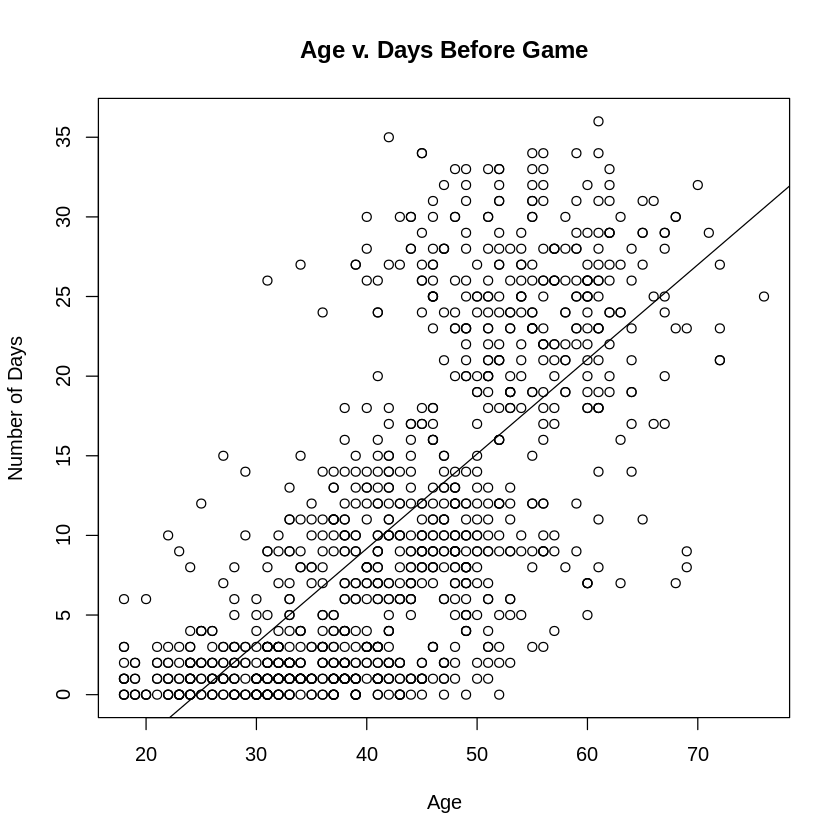

In [17]:
plot(warriorsData$Age, warriorsData$Days_Before_Game,
        main = "Age v. Days Before Game", xlab = "Age", ylab = "Number of Days")
abline(modelLMSimple)

#### **Part 2:** Multiple linear regression model

Run the code cell below to fit a multiple linear regression model, where `Days_Before_Game` is modeled as a function of multiple $X$ variables.

In [18]:
modelLMMultiple <- lm(Days_Before_Game ~ Ticket_Price + Num_Tickets_Purchased + 
                        Seat_Location + Age + Fan_Mailing_List, 
                        data=warriorsData)
summary(modelLMMultiple)


Call:
lm(formula = Days_Before_Game ~ Ticket_Price + Num_Tickets_Purchased + 
    Seat_Location + Age + Fan_Mailing_List, data = warriorsData)

Residuals:
     Min       1Q   Median       3Q      Max 
-18.5774  -4.3187  -0.4717   3.3932  21.8170 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)           -9.646698   1.081799  -8.917  < 2e-16 ***
Ticket_Price          -0.001539   0.001573  -0.979    0.328    
Num_Tickets_Purchased  1.542508   0.130905  11.783  < 2e-16 ***
Seat_LocationUpper    -3.268948   0.470708  -6.945 6.84e-12 ***
Age                    0.411451   0.020412  20.157  < 2e-16 ***
Fan_Mailing_ListYes    2.953655   0.480186   6.151 1.11e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 6.399 on 994 degrees of freedom
Multiple R-squared:  0.5964,	Adjusted R-squared:  0.5944 
F-statistic: 293.8 on 5 and 994 DF,  p-value: < 2.2e-16


#### **Part 3:** Predict new observations

Now suppose we have five new observations. Run the code cell below to read in these data from a file. 


In [19]:
system("gdown --id 1nvZs_5cPMdVJzvv6hmJx07PB7qPV7zhi")
warriorsDataNew <- read_csv("warriors_data_new.csv")
warriorsDataNew$Customer_Type <- parse_factor(warriorsDataNew$Customer_Type, 
                                  levels=c("Last-Minute", "In-Between", "Planner"),
                                  ordered=TRUE)
head(warriorsDataNew)

Rows: 5 Columns: 11
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (6): customerID, customerName, Fan_Mailing_List, Customer_Type, Game_ID,...
dbl (5): Age, Num_Tickets_Purchased, Ticket_Price, Concession_Purchases, Day...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


customerID,customerName,Age,Fan_Mailing_List,Customer_Type,Game_ID,Num_Tickets_Purchased,Seat_Location,Ticket_Price,Concession_Purchases,Days_Before_Game
<chr>,<chr>,<dbl>,<chr>,<ord>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
13a19a2d8c0c6df2,"Turner, Nadia",52,No,Planner,685495b17d38,10,Lower,155.53,34.75,28
549329135798fb72,"Valadez, Joel",33,No,Last-Minute,fa672ddd6ed9,1,Upper,228.75,0.00,1
881b0abac250e536,"Byerhof, Austin",50,No,Last-Minute,b498d1ee4288,1,Upper,166.43,0.00,3
1bd5437a8b98bff3,"Wismer, Jillian",48,No,In-Between,ec759d4ded1c,2,Lower,325.78,0.00,7
cb41912524b8b601,"Dillon, Brandon",48,No,Planner,b48d95292b49,4,Lower,532.99,28.80,21


We can apply our two regression models to this data and observe the models' predictions. In the output of the cell below, `Days_Before_Game` represents the true value, `Simple_Prediction` represents the prediction of the simple linear regression model from Part 1, and `Multiple_Prediction` represents the prediction of the multiple linear regression model from Part 2.

In [20]:
regressionResults <- warriorsDataNew[ , c("customerID", "Days_Before_Game")]
regressionResults$Simple_Prediction <- predict(modelLMSimple, warriorsDataNew)
regressionResults$Multiple_Prediction <- predict(modelLMMultiple, warriorsDataNew)
regressionResults

customerID,Days_Before_Game,Simple_Prediction,Multiple_Prediction
<chr>,<dbl>,<dbl>,<dbl>
13a19a2d8c0c6df2,28,16.304673,26.934405
549329135798fb72,1,5.016153,1.852607
881b0abac250e536,3,15.116408,8.943206
1bd5437a8b98bff3,7,13.928142,12.686459
cb41912524b8b601,21,13.928142,15.452500


### **Categorical Outcome** (`Customer_Type`)

#### **Part 1:** Decision tree model

Run the cell below to build a **decision tree**, a type of machine learning model that makes predictions by inferring a set of logical rules from the data. The code cell will output a visualization of the tree.

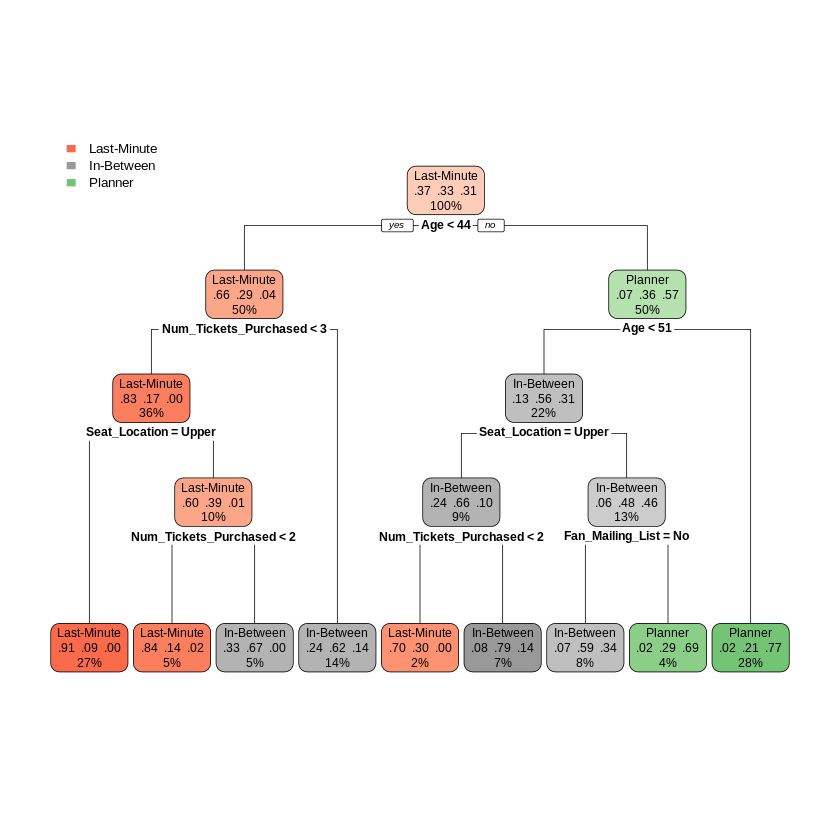

In [21]:
set.seed(565528)
dtModel <- rpart(Customer_Type ~ Ticket_Price + Num_Tickets_Purchased +
                  Seat_Location + Age + Fan_Mailing_List,
                  data = warriorsData)
rpart.plot(dtModel)

Run the cell below to determine the accuracy of the decision tree. This will also print a **confusion matrix**, or a table that compares the model's predictions to the true values. 

In [22]:
pred = predict(dtModel, type="class")
table(warriorsData$Customer_Type,pred)
print("Accuracy:")
sum(diag(table(warriorsData$Customer_Type, pred)))/sum(table(warriorsData$Customer_Type, pred))

             pred
              Last-Minute In-Between Planner
  Last-Minute         301         59       8
  In-Between           38        217      71
  Planner               1         57     248

[1] "Accuracy:"


[1] 0.766

#### **Part 2:** Predict new observations

Now let's apply the models to five new observations and observe the predictions. In the output of the cell below, `True_Customer_Type` represents the true value, the others represents the predictions from the decision tree in Part 1.


In [23]:
MLResults <- cbind(warriorsDataNew[ , c("customerID", "Customer_Type")], round(predict(dtModel, warriorsDataNew), 2))
# Rename the columns
names(MLResults) <- c("customerID", "True_Caustomer_Type", 
                      "probability-Last-Minute",
                      "probability-In-Between",
                      "probability-Planner")
MLResults

,customerID,True_Caustomer_Type,probability-Last-Minute,probability-In-Between,probability-Planner
,<chr>,<ord>,<dbl>,<dbl>,<dbl>
1,13a19a2d8c0c6df2,Planner,0.02,0.21,0.77
2,549329135798fb72,Last-Minute,0.91,0.09,0.00
3,881b0abac250e536,Last-Minute,0.70,0.30,0.00
4,1bd5437a8b98bff3,In-Between,0.07,0.59,0.34
5,cb41912524b8b601,Planner,0.07,0.59,0.34
